<a href="https://colab.research.google.com/github/lapatradaa/shap/blob/main/Teeth_Caries_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'panoramic-dental-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3419046%2F6067948%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240808%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240808T083736Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3fbd7a3000ec62fe8445e8d7aff50fae442c7bd6396d78f3a58c42d043ee8fe13696a6bcd918ef28955aed10a69c3d3e6e3e1443a79367fd58743f6703a0c3ace67a440f22e3f7030efaf2679337cc2b03be16d429463764cb9e920a5748fdc59f3c7627dc5a1162177f32c7f33887dc09149a12ea8cdeb870722da7a01d901a3542c915bf25591c954709cd74d3802495b52b47774a20d0e19137ea49cb9c43d2b99fd71429edef1c75807b0fba6ce78b649688601b9ea387993b90605b9bf671e518150dba8420c1fd83f9ad52362e2b37ce2b93fa8a616dcb587051aa5476403daefcab88774ded5cc1cdb36fd4349b05b309acd50ce6d50269b28fb6b56b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 255581868 bytes downloaded
Downloaded and uncompressed: panoramic-dental-dataset
Data source import complete.


# Teeth Caries UNET


https://arxiv.org/pdf/1505.04597.pdf

In [2]:
!pip install imantics --quiet

  Preparing metadata (setup.py) ... done


In [3]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imantics
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

In [4]:
images_dir ='/kaggle/input/panoramic-dental-dataset/images_cut'
masks_dir = '/kaggle/input/panoramic-dental-dataset/labels_cut'

In [5]:
images_listdir = os.listdir(images_dir)
masks_listdir = os.listdir(masks_dir)
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [6]:
print(len(images_listdir))
print(len(masks_listdir))

100
100


In [7]:
image_size=512
input_image_size=(512,512)

In [8]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [9]:
number=200

# Input images

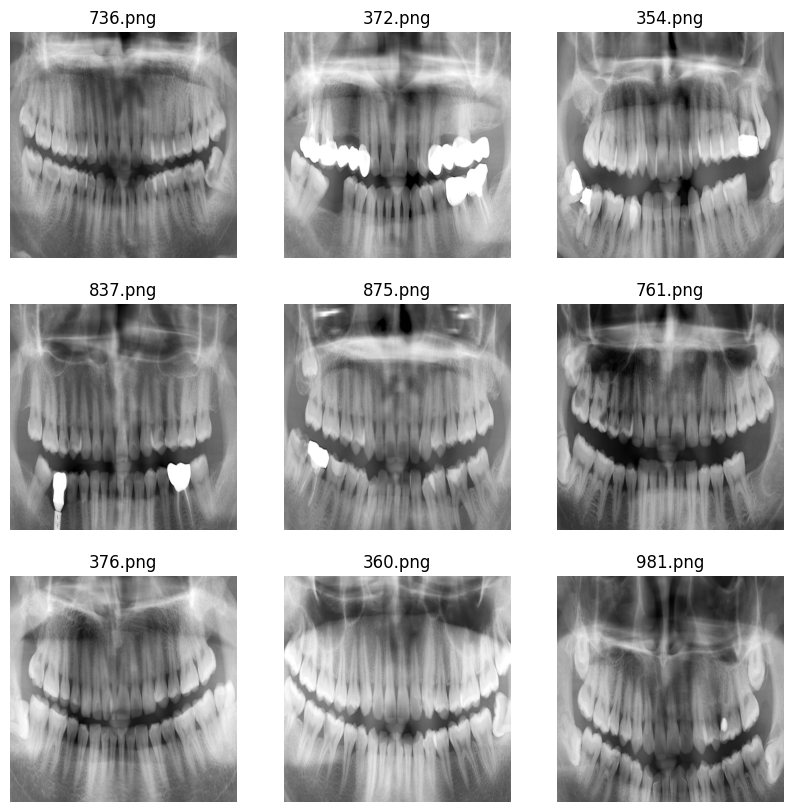

In [10]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

# Ground truth masks

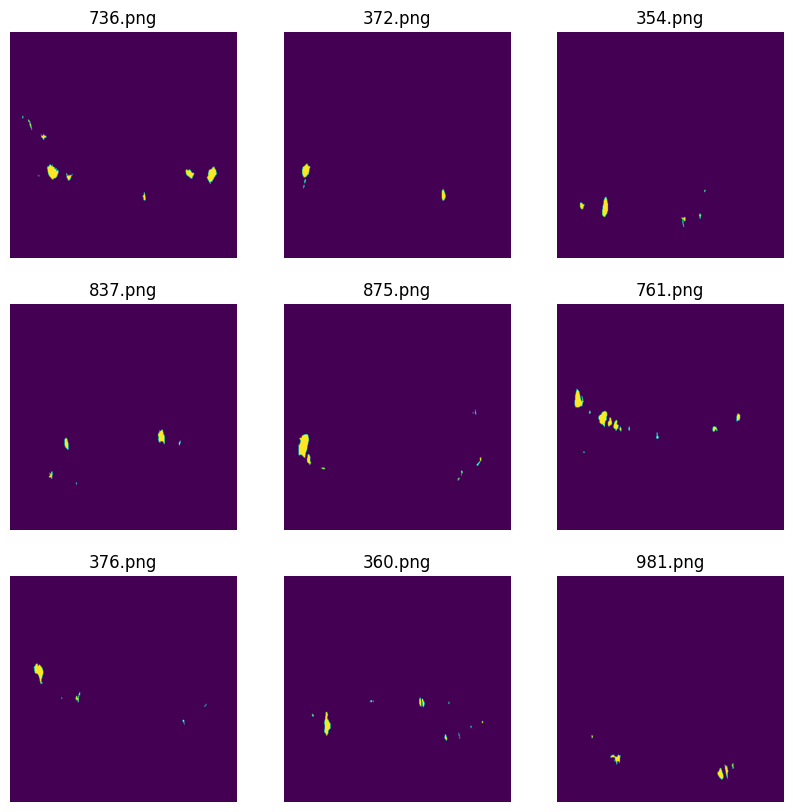

In [11]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [12]:
MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(images_listdir[0:number]):   ##the smaller, the faster
    try:
        image = read_image(f"{images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        mask = read_image(f"{masks_dir}/{file}")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

In [13]:
images=np.array(IMAGES)[1:number+1]
masks=np.array(MASKS)[1:number+1]
print(images.shape,masks.shape)

(100, 512, 512, 3) (100, 512, 512, 1)


In [14]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.4, random_state=42)

In [15]:
print(len(images_train), len(masks_train))

60 60


# U-Net

In [16]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512,512,3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#unet_model.summary()

# Train
Suitable number epoch range is narrow.

In [17]:
unet_result = unet_model.fit(
    images_train, masks_train,
    validation_split = 0.2, batch_size = 4, epochs = 120)

Epoch 1/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.5420 - loss: -1.3750 - val_accuracy: 0.0000e+00 - val_loss: -93945.9922
Epoch 2/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8374 - loss: -8.9017 - val_accuracy: 0.0000e+00 - val_loss: -273268.1562
Epoch 3/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7820 - loss: -11.3346 - val_accuracy: 8.5831e-06 - val_loss: -71.2209
Epoch 4/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8405 - loss: -15.0955 - val_accuracy: 3.1789e-06 - val_loss: -2540.4531
Epoch 5/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7791 - loss: -22.4234 - val_accuracy: 3.3283e-04 - val_loss: 95.2950
Epoch 6/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7016 - loss: -29.7636 - val_accuracy: 5.3946e-04 - val_loss: -95.2187
Epoch 7/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6310 - loss: -32.0543 - val_accuracy: 0.0000e+00 - val_loss: -28700.6348
Epoch 8/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/

# Predict valid images

In [18]:
def show_result(idx, og, unet, target, p):

    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')

    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet)
    axs[1].axis('off')

    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [19]:
unet_predict = unet_model.predict(images_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 142s 36s/step


In [20]:
len(images_test)

40

In [21]:
r1,r2,r3,r4=0.6,0.7,0.8,0.9

In [22]:
unet_predict1 = (unet_predict > r1).astype(np.uint8)
unet_predict2 = (unet_predict > r2).astype(np.uint8)
unet_predict3 = (unet_predict > r3).astype(np.uint8)
unet_predict4 = (unet_predict > r4).astype(np.uint8)

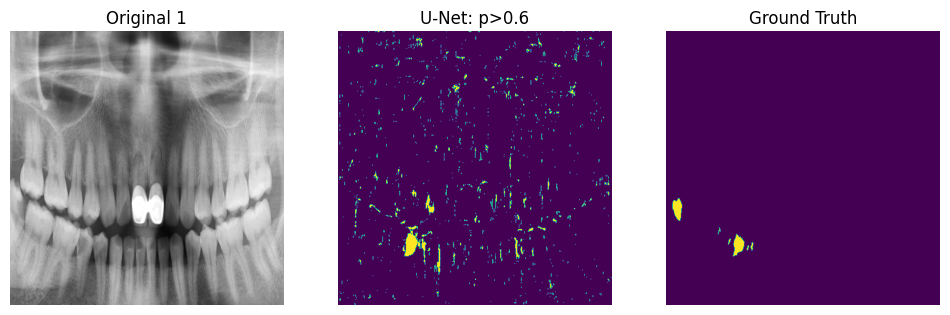

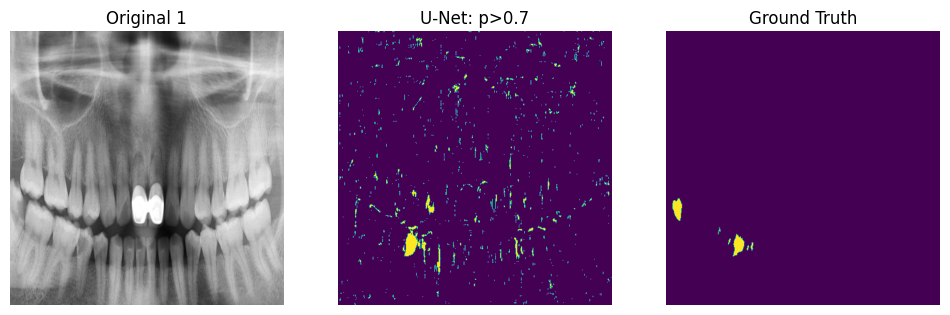

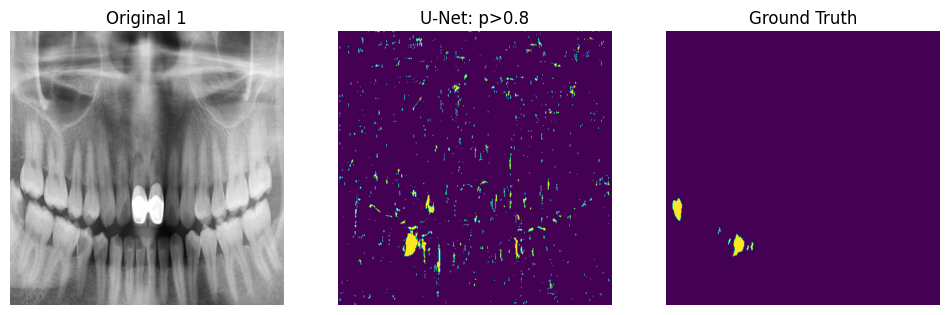

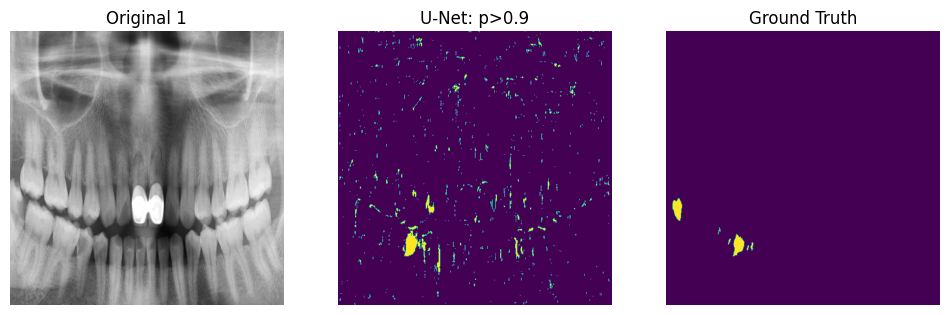

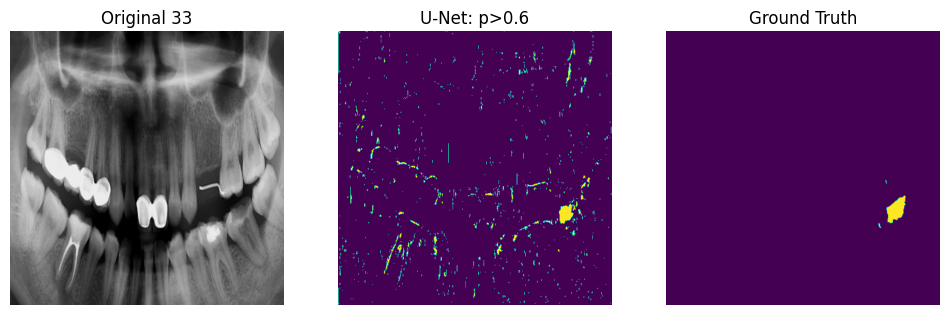

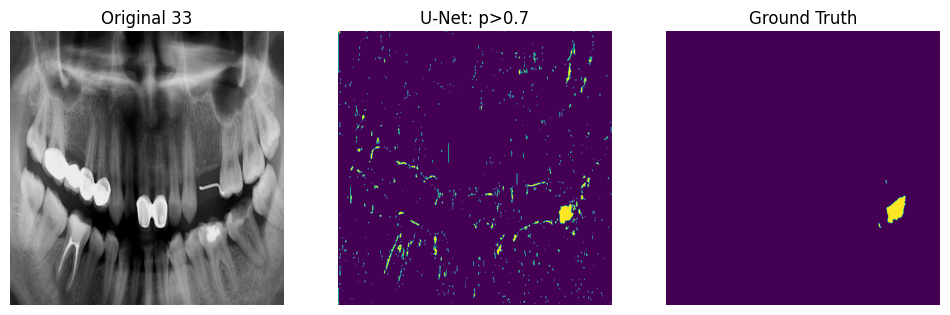

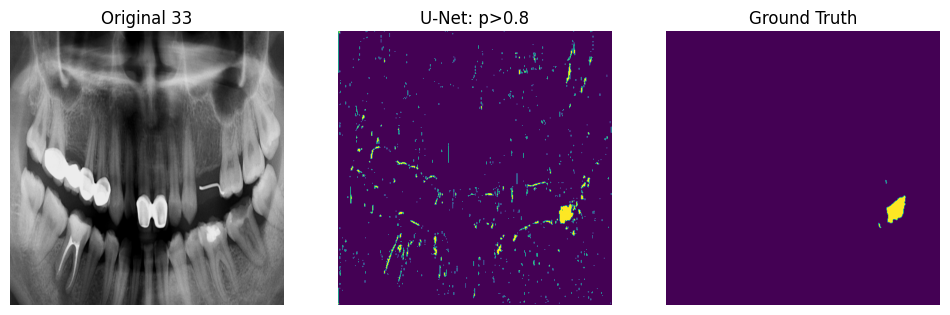

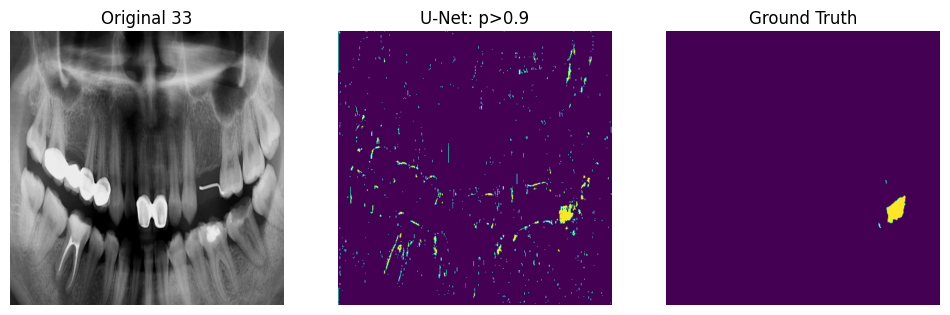

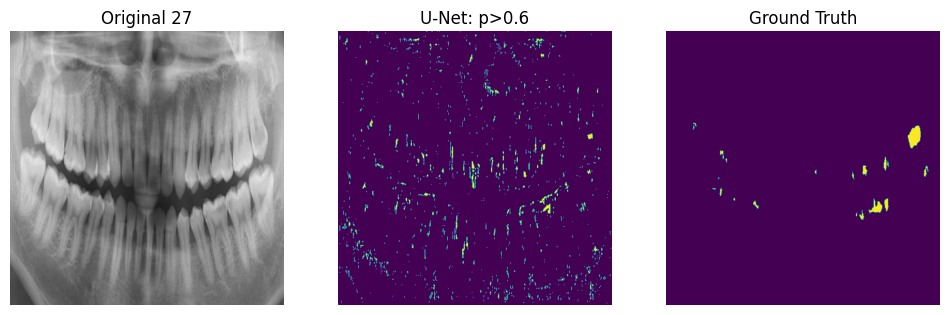

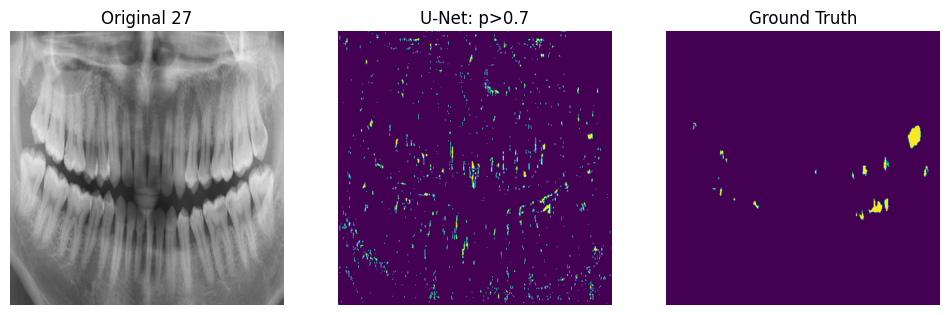

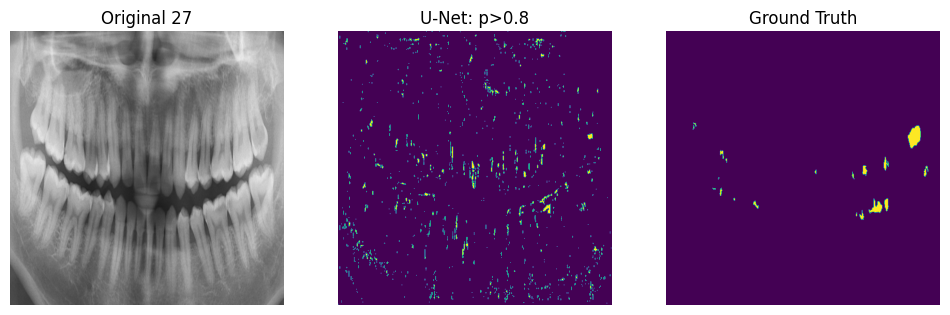

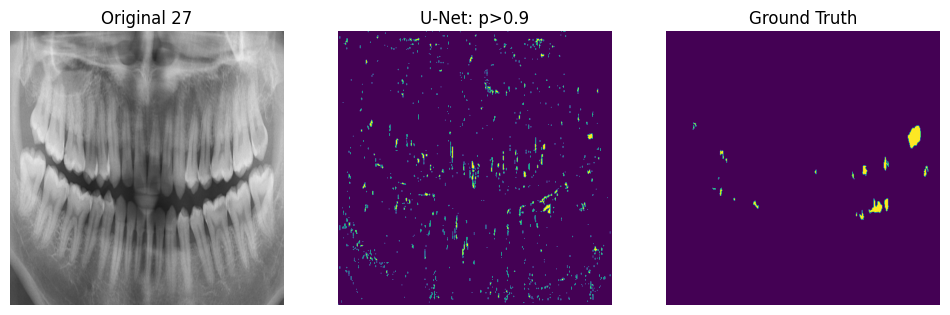

In [23]:
show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx:
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)
    show_result(idx, images_test[idx], unet_predict2[idx], masks_test[idx], r2)
    show_result(idx, images_test[idx], unet_predict3[idx], masks_test[idx], r3)
    show_result(idx, images_test[idx], unet_predict4[idx], masks_test[idx], r4)
    print()